In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


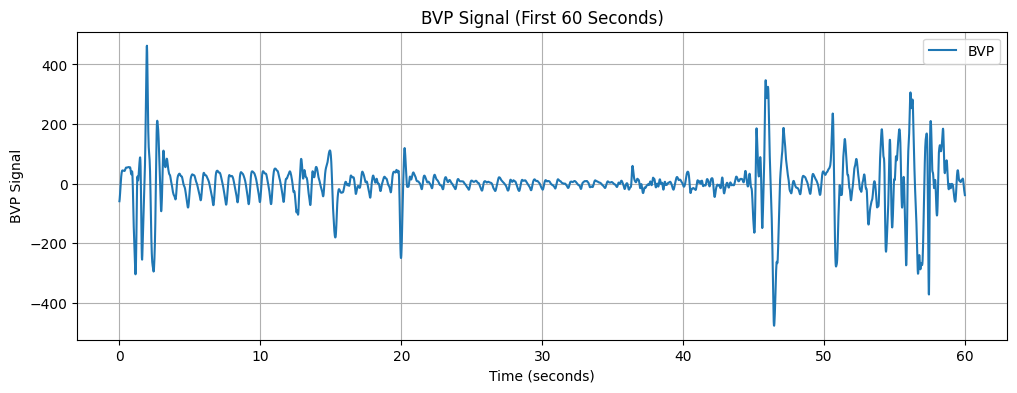

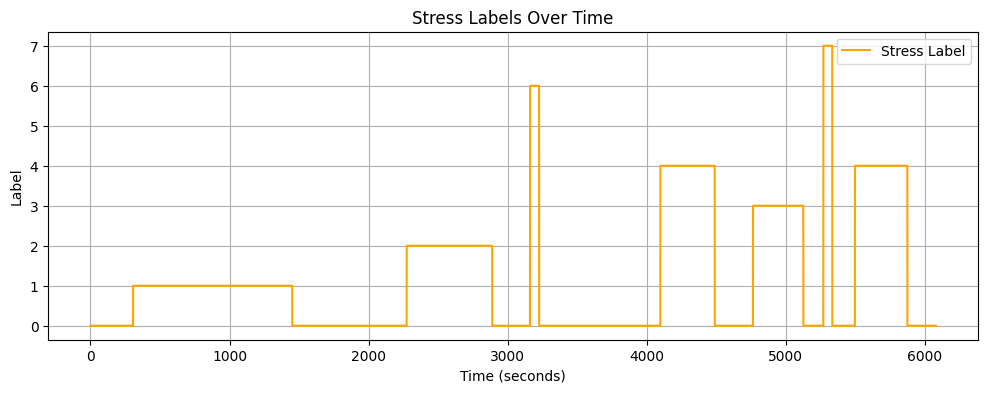

In [9]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the WESAD subject file
pkl_file = '/content/drive/MyDrive/WESAD_pkl/S2.pkl'
with open(pkl_file, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

# Extract signals
bvp = data['signal']['wrist']['BVP']   # 64 Hz
eda = data['signal']['wrist']['EDA']   # 4 Hz
temp = data['signal']['wrist']['TEMP'] # 4 Hz
labels = data['label']                 # 700 Hz

# Time arrays
samples = 60 * 64  # 60 seconds * 64 Hz
bvp_time = np.arange(samples) / 64  # in seconds
label_time = np.arange(len(labels)) / 700  # in seconds

# --- Plot BVP for 60 seconds ---
plt.figure(figsize=(12, 4))
plt.plot(bvp_time, bvp[:samples], label='BVP')
plt.xlabel('Time (seconds)')
plt.ylabel('BVP Signal')
plt.title('BVP Signal (First 60 Seconds)')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot Stress Labels over Time ---
plt.figure(figsize=(12, 4))
plt.plot(label_time, labels, label='Stress Label', color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('Label')
plt.title('Stress Labels Over Time')
plt.grid(True)
plt.legend()
plt.show()


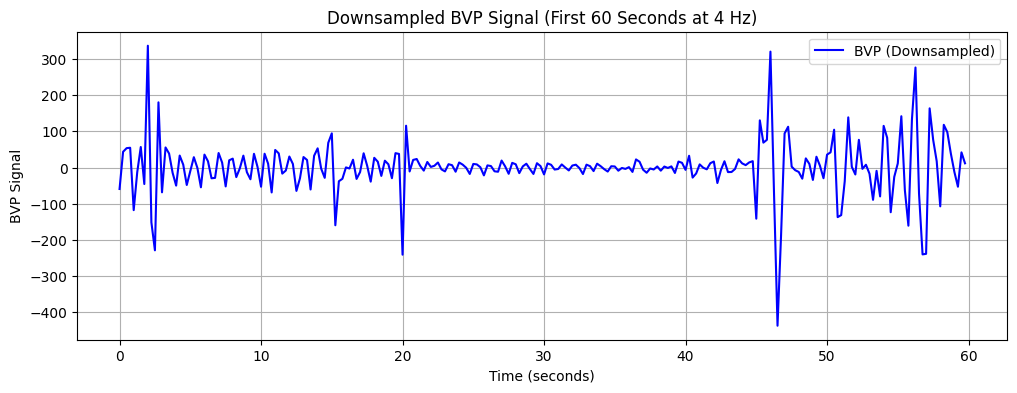

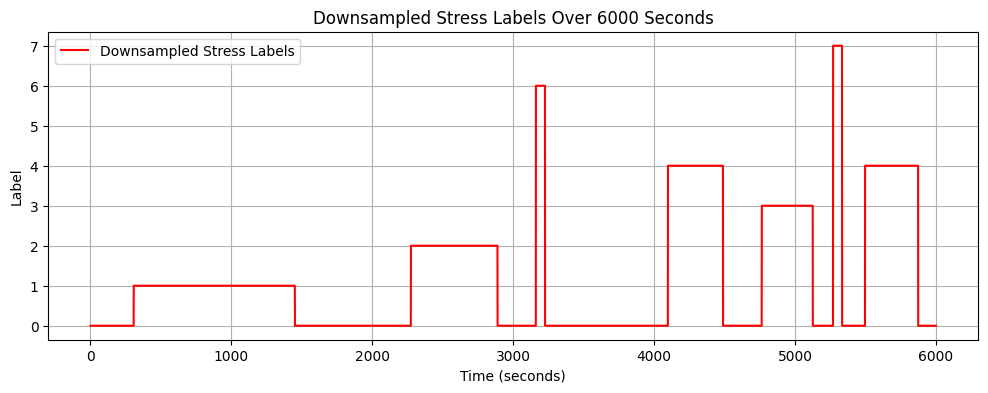

In [10]:
# Downsample the signals
bvp_downsampled = np.array(bvp[::16]).flatten()         # 64 Hz → 4 Hz
label_downsampled = np.array(labels[::175]).flatten()   # 700 Hz → 4 Hz

# Select first 60 seconds (4 samples/sec * 60 sec = 240 samples)
samples_60s = 60 * 4

# Create time axis for 60 seconds
time_60s = np.arange(0, samples_60s) / 4  # in seconds

duration_seconds = 6000
sampling_rate = 4  # after downsampling
samples_to_plot = duration_seconds * sampling_rate

# Time axis
time_6000s = np.arange(samples_to_plot) / sampling_rate
# --- Plot Downsampled BVP for 60 seconds ---
plt.figure(figsize=(12, 4))
plt.plot(time_60s, bvp_downsampled[:samples_60s], label='BVP (Downsampled)', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('BVP Signal')
plt.title('Downsampled BVP Signal (First 60 Seconds at 4 Hz)')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot Downsampled Labels for 60 seconds ---
# Plot
plt.figure(figsize=(12, 4))
plt.plot(time_6000s, label_downsampled[:samples_to_plot], label='Downsampled Stress Labels', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Label')
plt.title('Downsampled Stress Labels Over 6000 Seconds')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
print(len(bvp_downsampled))
print(len(eda))
print(len(temp))
print(len(label_downsampled))
print(len(label_downsampled))

print("EDA shape before flattening:", eda.shape)
print("EDA data before flattening:\n", eda)


print("temp shape before flattening:", temp.shape)
print("temp data before flattening:\n", temp)

df = pd.DataFrame({
    'BVP': bvp_downsampled,
    'EDA': eda.flatten(),
    'TEMP': temp.flatten(),
    'Label': label_downsampled
})


24316
24316
24316
24316
24316
EDA shape before flattening: (24316, 1)
EDA data before flattening:
 [[1.138257]
 [1.125444]
 [1.011405]
 ...
 [0.059208]
 [0.073303]
 [0.045113]]
temp shape before flattening: (24316, 1)
temp data before flattening:
 [[35.41]
 [35.41]
 [35.41]
 ...
 [34.23]
 [34.23]
 [34.23]]


In [13]:

# Define function to extract statistical features from a chunk
def extract_features(chunk):
    features = {}
    for signal in ['BVP', 'EDA', 'TEMP']:
        data = chunk[signal]
        features[f'{signal}_mean'] = np.mean(data)
        features[f'{signal}_std'] = np.std(data)
        features[f'{signal}_min'] = np.min(data)
        features[f'{signal}_max'] = np.max(data)
        features[f'{signal}_median'] = np.median(data)
        features[f'{signal}_skew'] = pd.Series(data).skew()
        features[f'{signal}_kurt'] = pd.Series(data).kurt()
    features['Label'] = chunk['Label'].iloc[0]
    return features

# Split into 60-second windows (240 rows)
window_size = 240
num_windows = len(df) // window_size

feature_rows = []

df= df[~df['Label'].isin([0, 5, 6, 7])]

for i in range(num_windows):
    start = i * window_size
    end = start + window_size
    chunk = df.iloc[start:end]

    # Ensure the chunk is valid (length == window_size)
    if len(chunk) != window_size:
        continue

    # Check if all labels in the chunk are the same
    if chunk['Label'].nunique() == 1:
        features = extract_features(chunk)
        feature_rows.append(features)

# Create DataFrame from extracted features
features_df = pd.DataFrame(feature_rows)

# Save to CSV
features_df.to_csv('S2_60sec_statistical_features.csv', index=False)

print("Saved", len(features_df), "feature rows to CSV.")



Saved 44 feature rows to CSV.


In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load the dataset
df = pd.read_csv('S2_60sec_statistical_features.csv')

# Separate features and labels
X = df.drop('Label', axis=1)
y = df['Label']

# Train-test split (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Save predictions with actual labels to CSV
results_df = pd.DataFrame({
    'True Label': y_test.reset_index(drop=True),
    'Predicted Label': pd.Series(y_pred)
})
results_df.to_csv('rf_predictions.csv', index=False)

print("\nSaved predictions to rf_predictions.csv")
print("\nSample predictions:\n", results_df.head())


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9


Confusion Matrix:
 [[4 0 0 0]
 [0 2 0 0]
 [0 0 1 0]
 [0 0 0 2]]

Saved predictions to rf_predictions.csv

Sample predictions:
    True Label  Predicted Label
0           1                1
1           1                1
2           3                3
3           2                2
4           2                2
